# <sup>27</sup>Al training process with DFT computed Al structures

In [1]:
import json
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.structure import Structure as ST

## 1. Get structures and NMR raw tensors.
------------------------------------------------------------

In [2]:
with open("data/Alnmr.json", "r") as file:
    data = json.load(file)
    print("length of file is {}".format(len(data)))

length of file is 3479


In [3]:
# test if there's any structure dosen't contain the target atom ('Al') and does not contain a structure section
problem_compound = []
for compound in data:
    if "structure" not in compound.keys():
        problem_compound.append(compound)
        continue
    sites = []
    for site in compound["structure"]["sites"]:
        sites.append(site["label"])
    if "Al" not in sites:
        problem_compound.append(compound)
print("num of problem compound:", len(problem_compound))

for compound in problem_compound:
    data.remove(compound)
print("len of none problematic data:", len(data))

num of problem compound: 8
len of none problematic data: 3471


In [4]:
# get rid of the redundances
for i in range(len(data)):
    string = json.dumps(data[i], sort_keys=True)
    data[i] = string
data = list(set(data))

for i in range(len(data)):
    dictionary = json.loads(data[i])
    data[i] = dictionary
print("length of file without redundancy is {}".format(len(data)))

length of file without redundancy is 3022


In [5]:
# get the structure_tensors obj
from src.structure_tensors_gen import get_structure_tensors
structure_tensors = get_structure_tensors(data)
print("length of structure_tensors:", len(structure_tensors))

  5%|▌         | 166/3022 [00:01<00:24, 117.67it/s]/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/pymatgen/analysis/nmr.py:201: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs((V[1] - V[0]) / V[2])
100%|██████████| 3022/3022 [00:22<00:00, 136.45it/s]

length of structure_tensors: 3022


In [16]:
# Here's what a structure_tensors obj looks like:
structure_tensors[0]['tensors']

[{'diso': 202.41719733333335,
  'csa': 2.6525442525691005,
  'csa_reduced': 1.7683628350460765,
  'etacs': 0.02050733360956661,
  'etaQ': 0.0013386880856760387,
  'CQ': -0.26479448758064145,
  'site_index': 0,
  'structure_index': 0,
  'site_coord': [-3.6580170004185675e-06, 4.608816971074, 6.78938336748],
  'coord_num': 6,
  'max_ce': 'O:6',
  'max_ce_value': 0.9204871064828781},
 {'diso': 202.41577799999996,
  'csa': 2.6575172424878986,
  'csa_reduced': 1.771678161658599,
  'etacs': 0.017191191110124692,
  'etaQ': 0.0,
  'CQ': -0.26479448758064145,
  'site_index': 1,
  'structure_index': 0,
  'site_coord': [3.9913546580170003, 2.304405028926, 3.1985533674799997],
  'coord_num': 6,
  'max_ce': 'O:6',
  'max_ce_value': 0.9204871064828783},
 {'diso': 202.41856400000006,
  'csa': 2.663769290965206,
  'csa_reduced': 1.775846193976804,
  'etacs': 0.007585938742260743,
  'etaQ': 0.0,
  'CQ': -0.26479448758064145,
  'site_index': 2,
  'structure_index': 0,
  'site_coord': [3.9913546580170003

## 2. Data cleaning and pre-training preparations 
---------------------------------------------------------------

In [ ]:
from src.structure_tensors_modifier import get_n_coord_tensors, append_coord_num, add_oxi_state_by_guess
# Add oxidation state for each structures in structure_tensors obj. Might take a long time based on the structure.
structure_tensors = add_oxi_state_by_guess(structure_tensors)
# Filter structure based on coordination number and append coord num info to "tensors".
structure_tensors_filtered = get_n_coord_tensors(structure_tensors, coord=[4, 5, 6])
structure_tensors_filtered = append_coord_num(structure_tensors_filtered)
len(structure_tensors_filtered)

In [11]:
# Add chemical environment info to "Tensor" list. Might take a long time based on the structure. 
from src.structure_tensors_modifier import append_ce
structure_tensors_filtered = append_ce(structure_tensors_filtered)

Append ChemEnv info to tensor list.

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



100%|██████████| 1862/1862 [29:35<00:00,  1.05it/s]


In [12]:
# Filter structures based on local chemenv. Here we select T:4 T:5 O:6 sites
from src.structure_tensors_modifier import filter_ce
chemenv_filter = filter_ce(structure_tensors_filtered)
# number of outliers
print("number of outliers:",len(chemenv_filter["outliers"]))

Filter structure_tensors based on ChemEnv info.


100%|██████████| 1862/1862 [00:00<00:00, 226831.08it/s]

num of structures with chemenv ['T:4', 'T:5', 'O:6'] only: 1681
number of outliers: 181


In [14]:
# Save the processed data for later direct use
processed_data = copy.deepcopy(chemenv_filter["filtered"])
for data in processed_data:
    data['structure'] = data['structure'].as_dict()
dir_ = "./data/"
filename = "processed_data_0.5.json"
with open(dir_+filename,'w') as outfile:
    json.dump(processed_data, outfile)

## 3. Visualization
----------------------------------------------

In [2]:
# Read processed data and continue
with open("./data/processed_data_0.5.json", "r") as file:
    data_reload = json.load(file)
for data in data_reload:
    data['structure'] = ST.from_dict(data['structure'])
print("length of data set is:", len(data_reload))

length of data set is: 1681


In [3]:
# Calculate the features.
from src.Utility import features_gen
nmr_struc_data = features_gen(data_reload)
nmr_struc_data.head()

  0%|          | 0/1681 [00:00<?, ?it/s]/mnt/c/Users/wusha/Documents/GitHub/27Al_CQ_prediction/src/local_features.py:626: RuntimeWarning: divide by zero encountered in reciprocal
  dis_matrix_rev = np.reciprocal(distance_matrix(coords_all,coords_all))
  0%|          | 2/1681 [00:00<03:50,  7.30it/s]/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:3938: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
100%|██████████| 1681/1681 [05:21<00:00,  5.23it/s]

There are 0 structures returns error. Their index are []
error_messages:
 []


,max_ce,structure_index,diso,etaQ,CQ,fbl_average,fbl_std,fbl_max,fbl_min,fba_average,...,110,111,112,113,114,115,116,117,118,119
0,O:6,0,202.417197,0.001339,0.264794,1.914520,0.083396,1.990656,1.838386,104.534489,...,7.808661e+06,9343.650957,6054.103924,5832.344530,5832.341162,533.498566,145.040097,132.941405,132.941328,95.242235
1,O:6,0,202.415778,0.000000,0.264794,1.914520,0.083396,1.990656,1.838386,104.534489,...,7.808661e+06,9343.650957,6054.103924,5832.344530,5832.341162,533.498566,145.040097,132.941405,132.941328,95.242235
2,O:6,0,202.418564,0.000000,0.264794,1.914520,0.083396,1.990656,1.838386,104.534489,...,7.808661e+06,9343.650957,6054.103924,5832.344530,5832.341162,533.498566,145.040097,132.941405,132.941328,95.242235
3,O:6,0,202.418705,0.001339,0.264794,1.914520,0.083396,1.990656,1.838386,104.534489,...,7.808661e+06,9343.650957,6054.103924,5832.344530,5832.341162,533.498566,145.040097,132.941405,132.941328,95.242235
8,O:6,3,196.472860,0.670647,1.521078,1.918155,0.032340,1.959752,1.873823,107.312413,...,7.808556e+06,8985.063376,6145.456281,5999.586723,5887.848974,529.391058,140.079201,136.754511,134.578866,97.192860


number of sites with T:4 is:  4696 
 number of sites with T:5 is:  202 
 number of sites with O:6 is:  3183 



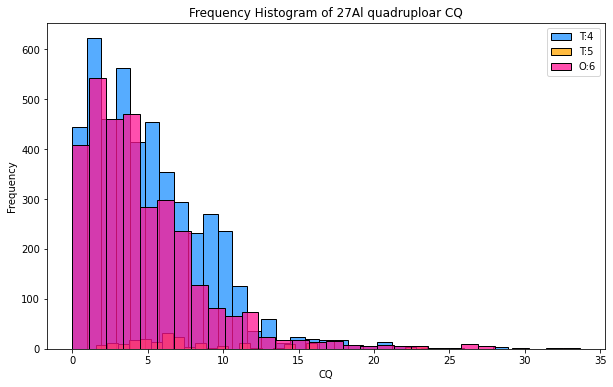

In [4]:
#plot hist of 27Al CQ colored based on type of chemical env.
x1 = nmr_struc_data.loc[nmr_struc_data.max_ce=='T:4', 'CQ']
x2 = nmr_struc_data.loc[nmr_struc_data.max_ce=='T:5', 'CQ']
x3 = nmr_struc_data.loc[nmr_struc_data.max_ce=='O:6', 'CQ']

print("number of sites with T:4 is: ", len(x1),'\n',
      "number of sites with T:5 is: ", len(x2),'\n',
      "number of sites with O:6 is: ", len(x3),'\n')

fig, ax = plt.subplots(figsize=[10, 6])
kwargs = dict(ax=ax,bins=30)

sns.histplot(x1, color="dodgerblue", label="T:4", **kwargs)
sns.histplot(x2, color="orange", label="T:5", **kwargs)
sns.histplot(x3, color="deeppink", label="O:6", **kwargs)
plt.gca().set(title='Frequency Histogram of 27Al quadruploar CQ', ylabel='Frequency')
plt.legend()

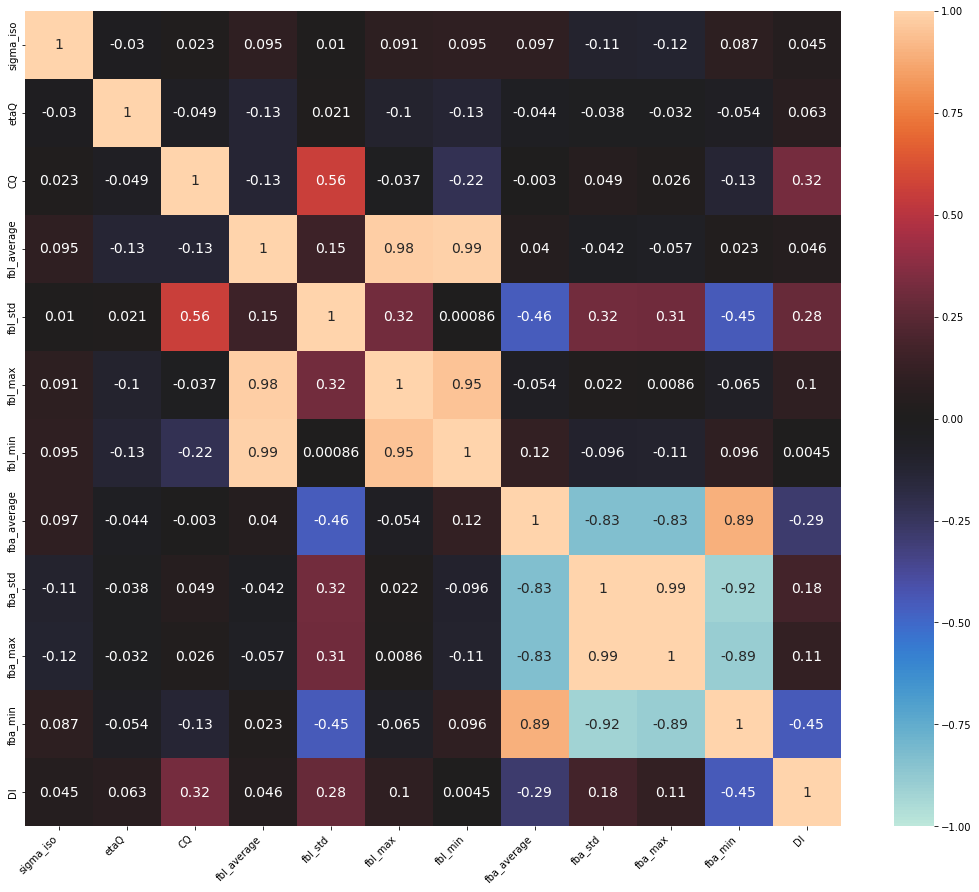

In [5]:
# heat map of structural features
corr = nmr_struc_data.rename(columns={'diso':'sigma_iso'}).loc[:, 'sigma_iso':"DI"].corr()

plt.figure(figsize=[19, 15])
heat_map = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    #     cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    annot_kws={"size": 14},
)
heat_map.set_xticklabels(
    heat_map.get_xticklabels(), rotation=45, horizontalalignment="right"
)
sns.set(font_scale=1.5)
plt.savefig("./figures/27Al_color_map.png", format="png", bbox_inches="tight")
plt.show()

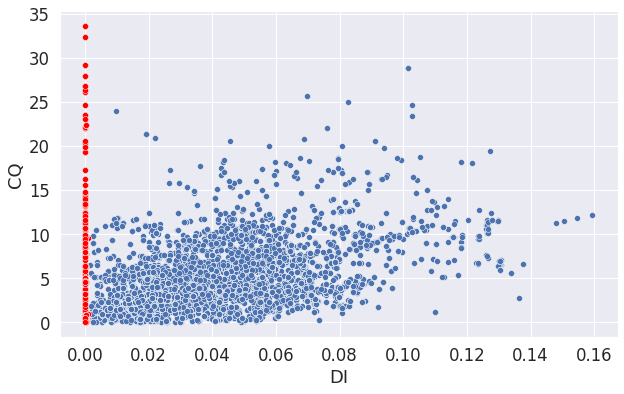

In [6]:
# Noticed that the distrotion index can not correctly represent some of the local geometries. (red labeled ones)
red_labels = nmr_struc_data[
    (nmr_struc_data["DI"] < 0.001) & (nmr_struc_data["CQ"] > 0)
]

fig, ax = plt.subplots(figsize=[10, 6])
sns.scatterplot(data=nmr_struc_data, x='DI', y='CQ', ax=ax)
sns.scatterplot(data=red_labels, x='DI', y='CQ', ax=ax, color="red")
plt.show()

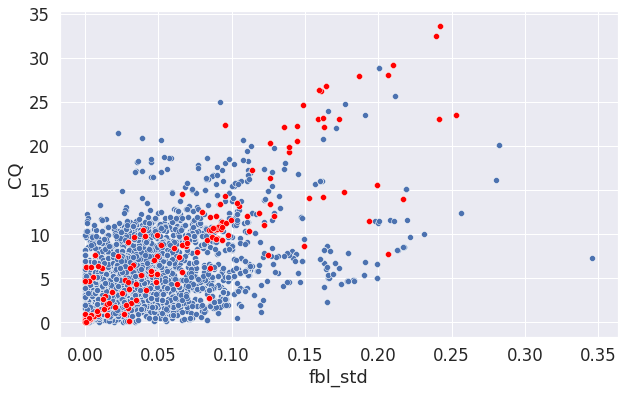

In [7]:
# And these unrepresented geometries are nicely represented by the standard deviation of first order bond length. 
fig, ax = plt.subplots(figsize=[10, 6])
sns.scatterplot(data = nmr_struc_data, x='fbl_std', y='CQ',ax=ax)
sns.scatterplot(data = red_labels, x='fbl_std', y='CQ', ax=ax, color="red")
plt.show()

## 4. Model training 
------------------------------------------------
1. Random forest
2. GBDT (XGboost)

In [15]:
# split y and x
y = nmr_struc_data[["CQ","max_ce","structure_index"]]
x = nmr_struc_data.loc[:, 'fbl_average':]

# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=20
)

print(f"Size of train set: {len(X_train)}\nSize of test set: {len(X_test)}")

Size of train set: 6464
Size of test set: 1617


### Random forest

In [9]:
%%time
# Grid Search for Algorithm Tuning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import math

# create and fit a kernel ridge regression model
model = RandomForestRegressor(random_state=10,min_samples_split=4,min_samples_leaf=2)

param = {"n_estimators": randint(low=100, high=500), 
         "max_depth": uniform(10, 200),
         "max_features": ['auto', 'sqrt','log2']
         }

grid_rf = RandomizedSearchCV(
    estimator=model,
    param_distributions=param,
    n_iter=10,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"],
    refit="r2",
    cv=5,
    n_jobs=8,
)
grid_rf.fit(X_train, y_train['CQ'])

# summarize the results of the grid search
train_r2 = np.sort(grid_rf.cv_results_["mean_test_r2"])[-1]
train_RMSE = math.sqrt(
    -np.sort(grid_rf.cv_results_["mean_test_neg_mean_squared_error"])[-1]
)
train_MAE = -np.sort(grid_rf.cv_results_["mean_test_neg_mean_absolute_error"])[-1]

print(
    "training score: R2 = {}, RMSE = {}, MAE = {}".format(
        train_r2, train_RMSE, train_MAE
    )
)
print(grid_rf.best_estimator_)

training score: R2 = 0.949567121929122, RMSE = 0.9070453030931546, MAE = 0.3919070033345294
RandomForestRegressor(max_depth=83.97179787864387, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=4, n_estimators=403,
                      random_state=10)
CPU times: user 11.2 s, sys: 261 ms, total: 11.5 s
Wall time: 4min 34s


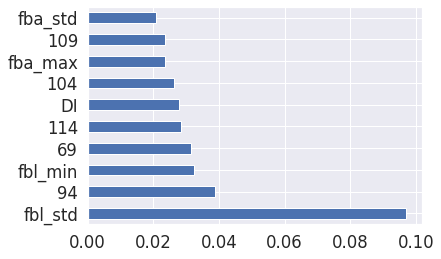

In [10]:
#plot feature importance 
feat_importances = pd.Series(grid_rf.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

test scores: R2 = 0.9739345821604951, RMSE = 0.6280366993955225, MAE = 0.3085126253458137
date and time: 22-02-2022_01-43-05


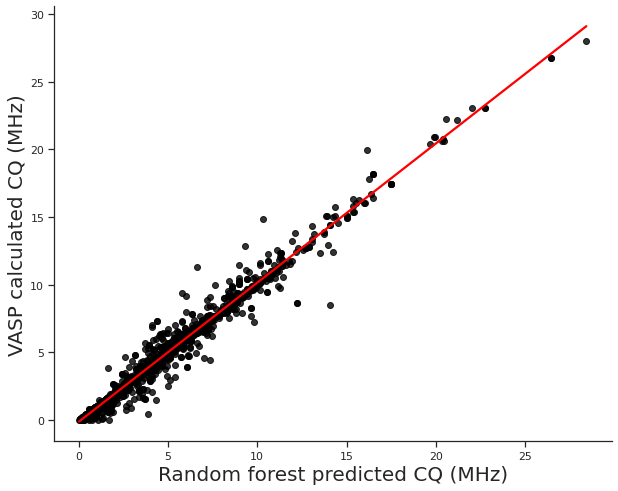

CPU times: user 479 ms, sys: 101 ms, total: 581 ms
Wall time: 331 ms


In [11]:
%%time
# Predict test set
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

sns.set()
import matplotlib.pyplot as plt
from datetime import datetime

y_rf = grid_rf.predict(X_test)

test_r2 = r2_score(y_test["CQ"], y_rf)
test_RMSE = math.sqrt(mean_squared_error(y_test['CQ'], y_rf))
test_MAE = mean_absolute_error(y_test['CQ'], y_rf)

print("test scores: R2 = {}, RMSE = {}, MAE = {}".format(test_r2, test_RMSE, test_MAE))


# write down the date for png save
predict_result = {}
predict_result["VASP_CQ"] = y_test['CQ']
predict_result["RF_predicted_CQ"] = y_rf
predict_result = pd.DataFrame(predict_result)

# datetime object containing current date and time
now = datetime.now() 
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print("date and time:",dt_string)

#plot the correlation
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (10,8))
plot = sns.regplot(
    x="RF_predicted_CQ",
    y="VASP_CQ",
    data=predict_result,
    ci=None,
    scatter_kws={"color": "black"}, 
    line_kws={"color": "red"}
)
ax.set_xlabel("Random forest predicted CQ (MHz)",fontsize=20)
ax.set_ylabel("VASP calculated CQ (MHz)",fontsize=20)
sns.despine()
# plt.savefig('./figures/27Al_RF_testSet_{}.png'.format(dt_string))
plt.show()

# # Export y_rf and y_test as .csv
# y_output = copy.deepcopy(y_test)
# y_output['CQ_rf'] = y_rf
# y_output = pd.DataFrame(y_output)
# y_output.to_csv('./data/All_feature_test.csv')

### GBDT (XGboost)

In [18]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import math

model = xgboost.XGBRegressor(tree_method = "hist")

param = {"learning_rate":uniform(0, 1),
         "max_depth":randint(3,20),
         "min_child_weight": randint(1,10),
         "eta":uniform(0.01,0.2),
         "gamma": uniform(0,1),
         'reg_alpha': [1e-5,1e-2,0.1,1,100],
         'subsample':uniform(0,1),
         'colsample_bytree':uniform(0,1)
         }
grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param,
    n_iter=10,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"],
    refit="r2",
    cv=5,
)
grid.fit(X_train, y_train['CQ'])

# summarize the results of the grid search
train_r2 = np.sort(grid.cv_results_["mean_test_r2"])[-1]
train_RMSE = math.sqrt(
    -np.sort(grid.cv_results_["mean_test_neg_mean_squared_error"])[-1]
)
train_MAE = -np.sort(grid.cv_results_["mean_test_neg_mean_absolute_error"])[-1]

print(
    "training score: R2 = {}, RMSE = {}, MAE = {}".format(
        train_r2, train_RMSE, train_MAE
    )
)
print(grid.best_estimator_)

training score: R2 = 0.9682562411518901, RMSE = 0.7186016527201513, MAE = 0.2742803938929143
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4589358806327798,
             enable_categorical=False, eta=0.11681886083444123,
             gamma=0.16561051031729723, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15922968263219994,
             max_delta_step=0, max_depth=19, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1,
             subsample=0.9919370606898825, tree_method='hist',
             validate_parameters=1, verbosity=None)


test scores: R2 = 0.9846922270072505, RMSE = 0.4812920449772071, MAE = 0.1857610001122533
date and time: 22-02-2022_01-55-03


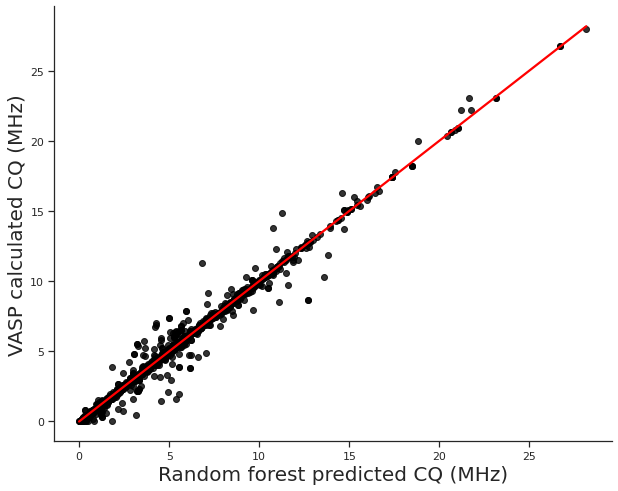

CPU times: user 507 ms, sys: 141 ms, total: 648 ms
Wall time: 296 ms


In [19]:
%%time
# Predict test set
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

sns.set()
import matplotlib.pyplot as plt
from datetime import datetime

y_rf = grid.predict(X_test)

test_r2 = r2_score(y_test["CQ"], y_rf)
test_RMSE = math.sqrt(mean_squared_error(y_test['CQ'], y_rf))
test_MAE = mean_absolute_error(y_test['CQ'], y_rf)

print("test scores: R2 = {}, RMSE = {}, MAE = {}".format(test_r2, test_RMSE, test_MAE))


# write down the date for png save
predict_result = {}
predict_result["VASP_CQ"] = y_test['CQ']
predict_result["RF_predicted_CQ"] = y_rf
predict_result = pd.DataFrame(predict_result)

# datetime object containing current date and time
now = datetime.now() 
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print("date and time:",dt_string)

sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (10,8))
plot = sns.regplot(
    x="RF_predicted_CQ",
    y="VASP_CQ",
    data=predict_result,
    ci=None,
    scatter_kws={"color": "black"}, 
    line_kws={"color": "red"}
)
ax.set_xlabel("Random forest predicted CQ (MHz)",fontsize=20)
ax.set_ylabel("VASP calculated CQ (MHz)",fontsize=20)
sns.despine()
# plt.savefig('./figures/27Al_RF_testSet_{}.png'.format(dt_string))
plt.show()

In [44]:
# save the model to disk
import pickle
dir_ = "./models/best/"
filename = 'Best_model_10132021.sav'
pickle.dump(grid, open(dir_+filename, 'wb'))